In [1]:
import pandas as pd
import numpy as np
import rethinkdb as r
from sklearn.feature_extraction import DictVectorizer
from sklearn import cross_validation, metrics, preprocessing
from tensorflow.contrib import learn
import matplotlib.pyplot as plt
import matplotlib

from demo_backend.models import db

In [2]:
%matplotlib inline

In [3]:
def preprocessing_data():
    conn = r.connect('localhost', '28015')
    cursor = db.table('township_village') \
        .pluck(['county', 'township', 'village', 'scores', 'average_income_per_capita']).run(conn)
    villages = []

    for item in cursor:
        incomes = []
        for income in item['average_income_per_capita']:
            data = {}
            data['avg_income'] = np.sum([
                income['distribution']['below_5k'] * 2500,
                income['distribution']['5k_10k'] * (5000 + 10000) / 2,
                income['distribution']['10k_15k'] * (10000 + 15000) / 2,
                income['distribution']['15k_20k'] * (15000 + 20000) / 2,
                income['distribution']['20k_25k'] * (20000 + 25000) / 2,
                income['distribution']['above_25k'] * 25000,
            ])
            data['year'] = income['year']
            incomes.append(data)

        result = pd.merge(pd.DataFrame(incomes), pd.DataFrame(item['scores']), on='year')
        result['township'] = item['township']
        result['village'] = item['village']
        villages.append(result)

    conn.close()
    return pd.concat(villages)

In [4]:
data = preprocessing_data()

In [5]:
feature_cols = [col for col in data.columns if col not in [u'overall']]
x = data[feature_cols].to_dict(orient='records')
y = data[u'overall'].values

In [6]:
vec = DictVectorizer()
features = vec.fit_transform(x)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(features, y)

test_data = data[feature_cols].iloc[0].to_dict()

x_test = vec.transform(test_data)

model.predict(x_test)

array([ 29.32890187])

In [8]:
x = features.toarray()
y = data[u'overall'].values

# Split dataset into train / test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=42)

# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)

# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = learn.DNNRegressor(hidden_units=[105, 50])

# Fit
regressor.fit(x_train, y_train, steps=5000, batch_size=1)

# Predict and score
y_predicted = regressor.predict(scaler.transform(x_test))
score = metrics.mean_squared_error(y_test, y_predicted)

print('MSE: {0:f}'.format(score))


MSE: 0.096334


In [9]:
d = pd.DataFrame([pd.DataFrame(x_test)[104].values, y_predicted, y_test]).transpose()

In [10]:
matplotlib.style.use('ggplot')

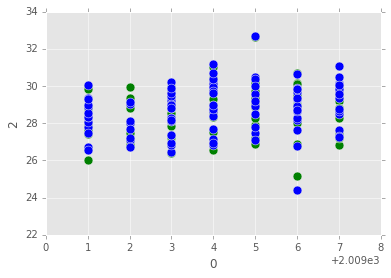

In [11]:
ax = d.plot.scatter(x=0, y=1, s=5*5*3.15, color='Green')
d.plot.scatter(x=0, y=2, s=5*5*3.15, color='Blue', ax=ax)

In [12]:
X = np.random.uniform(0, 10.0, size=100).astype(np.float32)

In [13]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [14]:
# Observations
y = f(X).ravel()

In [15]:
dy = 1.5 + 1.0 * np.random.random(y.shape)
dy

array([ 2.44186332,  2.44840499,  1.56045428,  2.35952771,  2.30953638,
        2.08462387,  1.82329478,  1.93719488,  1.61814154,  1.93063034,
        1.6423547 ,  2.24453235,  1.8519885 ,  1.91950286,  1.95090379,
        2.03253551,  1.64750704,  1.78400065,  2.2862911 ,  2.05316523,
        2.22528648,  2.43088407,  1.6368822 ,  2.22559511,  1.50582591,
        1.94539091,  2.42458131,  1.6275256 ,  1.95287336,  1.62327662,
        2.47596097,  2.2928817 ,  1.89458221,  2.16216544,  2.1167665 ,
        2.35453534,  1.9520339 ,  2.35372493,  2.17474054,  1.88465656,
        1.90811025,  1.63407543,  1.53452239,  1.84066683,  2.03718591,
        2.01200672,  1.8687277 ,  2.33710568,  2.1623087 ,  1.86064909,
        2.03502014,  2.02050021,  2.47080859,  1.50090628,  1.54153007,
        2.24798599,  1.79240531,  1.92448815,  2.34419708,  1.82425823,
        2.04145957,  2.39325222,  1.93522689,  1.62711437,  2.49704716,
        2.19034946,  1.96500879,  1.59232386,  2.03315528,  1.52

In [16]:
def preprocessing_data():
    conn = r.connect('localhost', '28015')
    cursor = db.table('township_village_coordinates').run(conn)
    villages = []

    for item in cursor:
        incomes = []
        for income in item['average_income_per_capita']:
            data = {}
            data['avg_income'] = np.sum([
                income['distribution']['below_5k'] * 2500,
                income['distribution']['5k_10k'] * (5000 + 10000) / 2,
                income['distribution']['10k_15k'] * (10000 + 15000) / 2,
                income['distribution']['15k_20k'] * (15000 + 20000) / 2,
                income['distribution']['20k_25k'] * (20000 + 25000) / 2,
                income['distribution']['above_25k'] * 25000,
            ])
            data['year'] = income['year']
            incomes.append(data)

        result = pd.merge(pd.DataFrame(incomes), pd.DataFrame(item['scores']), on='year')
        result['township'] = item['township']
        result['village'] = item['village']
        villages.append(result)

    conn.close()
    return pd.concat(villages)

In [17]:
def grab_scores():
    conn = r.connect('localhost', '28015')

    score_tb = r.db('impact_learning').table('score')
    coordinates_tb = r.db('impact_learning').table('township_village_coordinates')

    cursor = score_tb.inner_join(coordinates_tb, lambda s, c: s['township'] + s['village'] == c['id']).zip().run(conn)

    data = []
    for d in cursor:
        data.append(d)

    conn.close()
    return data

In [18]:
data = grab_scores()

In [19]:
len(data)

5621

In [20]:
data = pd.DataFrame(data)

In [21]:
data.columns

Index([u'age_below6_or_above60', u'agri_tool', u'attend_lesson',
       u'auto_transportation', u'color_tv', u'coordinates', u'date', u'edu_lv',
       u'familiy_member', u'family_insurance',
       u'family_member_earn_from_other_industry', u'fridge', u'fuel_type',
       u'house_material', u'id', u'member_work_out_of_town',
       u'minimum_living_std_subsidy', u'overall', u'project', u'township',
       u'village', u'washing_machine', u'water_source'],
      dtype='object')

In [22]:
import datetime

In [23]:
data[u'date'] = pd.to_datetime(data[u'date'])

In [24]:
data[u'year'] = pd.DatetimeIndex(data[u'date']).year
data[u'month'] = pd.DatetimeIndex(data[u'date']).month

In [25]:
# Pick features for taining
feature_cols = [col for col in data.columns if col not in [
        u'date',
        u'overall',
        u'coordinates',
        u'id'
    ]]
x = data[feature_cols].to_dict(orient='records')
y = data[u'overall'].values

In [26]:
vec = DictVectorizer()
features = vec.fit_transform(x)

In [27]:
features.shape[1]

106

In [28]:
vec.get_feature_names()

[u'age_below6_or_above60',
 u'agri_tool',
 u'attend_lesson',
 u'auto_transportation',
 u'color_tv',
 u'edu_lv',
 u'familiy_member',
 u'family_insurance',
 u'family_member_earn_from_other_industry',
 u'fridge',
 u'fuel_type',
 u'house_material',
 u'member_work_out_of_town',
 u'minimum_living_std_subsidy',
 u'month',
 u'project',
 u'township=\u4e09\u6c5f\u4e61',
 u'township=\u4e09\u89d2\u4e61',
 u'township=\u516d\u5df7\u4e61',
 u'township=\u5927\u6a1f\u4e61',
 u'township=\u5934\u6392\u9547',
 u'township=\u5fe0\u826f\u4e61',
 u'township=\u6850\u6728\u9547',
 u'township=\u7f57\u9999\u4e61',
 u'township=\u91d1\u79c0\u9547',
 u'township=\u957f\u578c\u4e61',
 u'village=\u4e03\u5efa\u6751',
 u'village=\u4e09\u53cb\u6751',
 u'village=\u4e09\u53e4\u6751',
 u'village=\u4e09\u5408\u6751',
 u'village=\u4e09\u6c5f\u6751',
 u'village=\u4e09\u89d2\u6751',
 u'village=\u4e8c\u6392\u6751',
 u'village=\u4e92\u52a9\u6751',
 u'village=\u4ec1\u91cc\u6751',
 u'village=\u516d\u535c\u6751',
 u'village=\u516d\u5

In [29]:
x = features.toarray()
y = data[u'overall'].values

# Split dataset into train / test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=42)

# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)

# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = learn.DNNRegressor(hidden_units=[features.shape[1], round(features.shape[1]/2)])

# Fit
regressor.fit(x_train, y_train, steps=5000, batch_size=1)

# Predict and score
y_predicted = regressor.predict(scaler.transform(x_test))
score = metrics.mean_squared_error(y_test, y_predicted)

print('MSE: {0:f}'.format(score))


MSE: 0.119409


In [30]:
vec.get_feature_names()

[u'age_below6_or_above60',
 u'agri_tool',
 u'attend_lesson',
 u'auto_transportation',
 u'color_tv',
 u'edu_lv',
 u'familiy_member',
 u'family_insurance',
 u'family_member_earn_from_other_industry',
 u'fridge',
 u'fuel_type',
 u'house_material',
 u'member_work_out_of_town',
 u'minimum_living_std_subsidy',
 u'month',
 u'project',
 u'township=\u4e09\u6c5f\u4e61',
 u'township=\u4e09\u89d2\u4e61',
 u'township=\u516d\u5df7\u4e61',
 u'township=\u5927\u6a1f\u4e61',
 u'township=\u5934\u6392\u9547',
 u'township=\u5fe0\u826f\u4e61',
 u'township=\u6850\u6728\u9547',
 u'township=\u7f57\u9999\u4e61',
 u'township=\u91d1\u79c0\u9547',
 u'township=\u957f\u578c\u4e61',
 u'village=\u4e03\u5efa\u6751',
 u'village=\u4e09\u53cb\u6751',
 u'village=\u4e09\u53e4\u6751',
 u'village=\u4e09\u5408\u6751',
 u'village=\u4e09\u6c5f\u6751',
 u'village=\u4e09\u89d2\u6751',
 u'village=\u4e8c\u6392\u6751',
 u'village=\u4e92\u52a9\u6751',
 u'village=\u4ec1\u91cc\u6751',
 u'village=\u516d\u535c\u6751',
 u'village=\u516d\u5

In [31]:
d = pd.DataFrame([pd.DataFrame(x_test)[14].values, y_predicted, y_test]).transpose()

In [32]:
len(vec.get_feature_names())

106

In [42]:
pd.to_datetime(pd.DataFrame({
    'year': pd.DataFrame(x_test)[105].values,
    'month': pd.DataFrame(x_test)[14].values,
    'day': 1
})).values

array(['2010-04-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', ...,
       '2014-02-01T00:00:00.000000000', '2011-11-01T00:00:00.000000000',
       '2014-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [54]:
d = pd.DataFrame([pd.to_datetime(pd.DataFrame({
    'year': pd.DataFrame(x_test)[105].values,
    'month': pd.DataFrame(x_test)[14].values,
    'day': 1
})).values, y_predicted]).transpose()
d.columns = ['date', 'score']

In [55]:
d['score'] = d.score.astype(float)

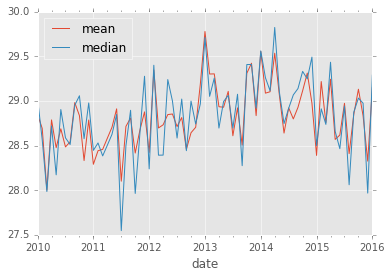

In [67]:
d.groupby('date')['score'].agg([np.mean, np.median]).plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113d8aa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f850f50>]], dtype=object)

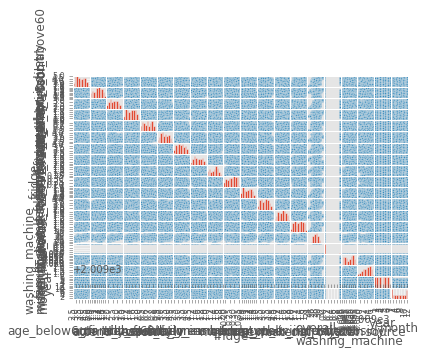

In [70]:
pd.scatter_matrix(data)

In [26]:
def grab_data():
    conn = r.connect('localhost', '28015')
    cursor = db.table('learning').pluck([
            'Score',
            'acu_donation',
            'acu_planting_area',
            'acu_plants',
            'date',
            'month',
            'year',
            'avg_income', 'project_stage']).run(conn)
    villages = []
    for item in cursor:
        villages.append(item)
    conn.close()
    return pd.DataFrame(villages)

In [27]:
data = grab_data()

In [28]:
# Pick features for taining
feature_cols = [col for col in data.columns if col not in [
        u'date',
        u'Score',
        u'coordinates',
        u'id'
    ]]
x = data[feature_cols].to_dict(orient='records')

vec = DictVectorizer()
features = vec.fit_transform(x)

x = features.toarray()
y = data[u'Score'].values

# Split dataset into train / test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=42)

# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)

# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = learn.DNNRegressor(hidden_units=[features.shape[1], round(features.shape[1]/2)])

# Fit
regressor.fit(x_train, y_train, steps=5000, batch_size=1)

# Predict and score
y_predicted = regressor.predict(scaler.transform(x_test))
score = metrics.mean_squared_error(y_test, y_predicted)

print('MSE: {0:f}'.format(score))

MSE: 2.068728


In [30]:
vec.get_feature_names()

[u'acu_donation',
 u'acu_planting_area',
 u'acu_plants',
 u'avg_income',
 u'month',
 u'project_stage=harvesting',
 u'project_stage=noActivity',
 u'project_stage=notSelected',
 u'project_stage=planting',
 u'project_stage=waitingForGrowth',
 u'project_stage=waitingForMaturity',
 u'year']

In [38]:
test_data = x_test[2]

In [62]:
x_test.shape

(1202, 12)

In [46]:
regressor.predict(scaler.transform(x_test[:6]))

array([ 28.50250244,  28.98783493,  29.0214386 ,  28.66592789,
        28.61182594,  28.65018082], dtype=float32)

In [55]:
test = data.groupby(['year', 'month']).mean().reset_index()

In [67]:
%matplotlib inline

In [71]:
import datetime

In [73]:
test

,year,month,Score,acu_donation,acu_planting_area,acu_plants,avg_income
0,2010,1,28.498640,0.000000,0.000000,0.000000,6121.364197
1,2010,2,28.501097,0.000000,0.000000,0.000000,6131.487754
2,2010,3,28.491528,0.000000,0.000000,0.000000,6137.785376
3,2010,4,28.493955,0.000000,0.000000,0.000000,6145.756540
4,2010,5,28.474308,0.000000,0.000000,0.000000,6156.800294
5,2010,6,28.477290,0.000000,0.000000,0.000000,6164.261029
6,2010,7,28.489272,0.000000,0.000000,0.000000,6170.357578
7,2010,8,28.494303,0.000000,0.000000,0.000000,6180.308394
8,2010,9,28.506655,0.000000,0.000000,0.000000,6190.279423
9,2010,10,28.508878,0.000000,0.000000,0.000000,6201.517007


In [76]:
test['date'] = pd.to_datetime(pd.DataFrame({'year': test.year,
             'month': test.month,
             'day': 1}))

In [78]:
test[['date', 'year']].to_dict()

{'date': {0: Timestamp('2010-01-01 00:00:00'),
  1: Timestamp('2010-02-01 00:00:00'),
  2: Timestamp('2010-03-01 00:00:00'),
  3: Timestamp('2010-04-01 00:00:00'),
  4: Timestamp('2010-05-01 00:00:00'),
  5: Timestamp('2010-06-01 00:00:00'),
  6: Timestamp('2010-07-01 00:00:00'),
  7: Timestamp('2010-08-01 00:00:00'),
  8: Timestamp('2010-09-01 00:00:00'),
  9: Timestamp('2010-10-01 00:00:00'),
  10: Timestamp('2010-11-01 00:00:00'),
  11: Timestamp('2010-12-01 00:00:00'),
  12: Timestamp('2011-01-01 00:00:00'),
  13: Timestamp('2011-02-01 00:00:00'),
  14: Timestamp('2011-03-01 00:00:00'),
  15: Timestamp('2011-04-01 00:00:00'),
  16: Timestamp('2011-05-01 00:00:00'),
  17: Timestamp('2011-06-01 00:00:00'),
  18: Timestamp('2011-07-01 00:00:00'),
  19: Timestamp('2011-08-01 00:00:00'),
  20: Timestamp('2011-09-01 00:00:00'),
  21: Timestamp('2011-10-01 00:00:00'),
  22: Timestamp('2011-11-01 00:00:00'),
  23: Timestamp('2011-12-01 00:00:00'),
  24: Timestamp('2012-01-01 00:00:00'),
  

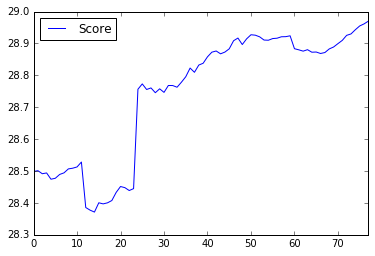

In [69]:
test[['Score']].plot()

In [57]:
regressor.predict(scaler.transform())

ValueError: operands could not be broadcast together with shapes (78,6) (12,) (78,6) 

In [9]:
from demo_backend.modeling import grab_data
import datetime

In [4]:
data = grab_data()

In [11]:
test = data.groupby(['year', 'month']).mean().reset_index()
test['date'] = pd.to_datetime(pd.DataFrame({
        'year': test.year,
        'month': test.month,
        'day': 1}))

In [46]:
test = data.groupby(['year', 'month'])['Score'].agg([np.mean, np.median, np.max, np.min, np.var, np.std]).reset_index()
test.columns = ['year', 'month', 'score', 'median', 'amax', 'amin', 'var', 'std']
test

,year,month,score,median,amax,amin,var,std
0,2010,1,28.498640,28.530497,32.207528,24.912194,1.608624,1.268316
1,2010,2,28.501097,28.504412,32.267608,24.940016,1.614834,1.270761
2,2010,3,28.491528,28.472084,32.162971,24.966194,1.646703,1.283239
3,2010,4,28.493955,28.470071,32.081936,25.055175,1.636975,1.279443
4,2010,5,28.474308,28.451139,32.101115,24.931985,1.648873,1.284084
5,2010,6,28.477290,28.413121,32.056804,24.890463,1.683720,1.297583
6,2010,7,28.489272,28.387276,32.097079,24.908827,1.713950,1.309179
7,2010,8,28.494303,28.396754,32.106173,24.955031,1.679734,1.296045
8,2010,9,28.506655,28.498414,32.270894,24.888038,1.720833,1.311805
9,2010,10,28.508878,28.552269,32.379100,24.863125,1.734978,1.317186


In [13]:
result = test[['date', 'Score']].to_json(orient='records', date_format='iso')

In [33]:
result

'[{"date":"2010-01-01T00:00:00.000Z","Score":28.4986398083},{"date":"2010-02-01T00:00:00.000Z","Score":28.5010966006},{"date":"2010-03-01T00:00:00.000Z","Score":28.4915275882},{"date":"2010-04-01T00:00:00.000Z","Score":28.493954856},{"date":"2010-05-01T00:00:00.000Z","Score":28.4743082377},{"date":"2010-06-01T00:00:00.000Z","Score":28.4772904748},{"date":"2010-07-01T00:00:00.000Z","Score":28.4892718165},{"date":"2010-08-01T00:00:00.000Z","Score":28.4943033841},{"date":"2010-09-01T00:00:00.000Z","Score":28.5066548239},{"date":"2010-10-01T00:00:00.000Z","Score":28.5088782188},{"date":"2010-11-01T00:00:00.000Z","Score":28.5128494557},{"date":"2010-12-01T00:00:00.000Z","Score":28.5281779558},{"date":"2011-01-01T00:00:00.000Z","Score":28.3855339319},{"date":"2011-02-01T00:00:00.000Z","Score":28.3772929144},{"date":"2011-03-01T00:00:00.000Z","Score":28.3712678818},{"date":"2011-04-01T00:00:00.000Z","Score":28.4003871194},{"date":"2011-05-01T00:00:00.000Z","Score":28.3969645924},{"date":"2011

In [18]:
import rethinkdb as r

In [29]:
conn = r.connect('localhost', '28015')
score_tb = db.table('learning').pluck([
        'Score',
        'acu_donation',
        'acu_planting_area',
        'acu_plants',
        'date',
        'month',
        'year',
        'township_village',
        'avg_income', 'project_stage'])
coordinates_tb = db.table('township_village_coordinates')
cursor = score_tb.inner_join(coordinates_tb, lambda s, c: s['township_village'] == c['id']).zip().run(conn)
villages = []
for item in cursor:
    villages.append(item)



[{u'Score': 28.0310746967,
  u'acu_donation': 0,
  u'acu_planting_area': 0,
  u'acu_plants': 0,
  u'avg_income': 6602.9390274029,
  u'coordinates': [110.08028863036449, 24.314590565412633],
  u'date': u'2012-12-01T00:00:00',
  u'id': u'\u5934\u6392\u9547\u540c\u6276\u6751',
  u'month': 12,
  u'project': False,
  u'project_stage': u'notSelected',
  u'township_village': u'\u5934\u6392\u9547\u540c\u6276\u6751',
  u'year': 2012},
 {u'Score': 30.9288683969,
  u'acu_donation': 648161.3495522388,
  u'acu_planting_area': 126.2059701493,
  u'acu_plants': 41104.4776119403,
  u'avg_income': 6905.7811844903,
  u'coordinates': [109.95256267722719, 23.922264391223198],
  u'date': u'2013-07-01T00:00:00',
  u'id': u'\u5927\u6a1f\u4e61\u53cc\u5316\u6751',
  u'month': 7,
  u'project': True,
  u'project_stage': u'waitingForMaturity',
  u'township_village': u'\u5927\u6a1f\u4e61\u53cc\u5316\u6751',
  u'year': 2013},
 {u'Score': 29.763269204,
  u'acu_donation': 0,
  u'acu_planting_area': 0,
  u'acu_plants':

In [31]:
d = pd.DataFrame(villages)

In [32]:
pd.to_datetime(pd.DataFrame({
            'year': d.year,
            'month': d.month,
            'day': 1
        }))

0      2012-12-01
1      2013-07-01
2      2011-02-01
3      2015-12-01
4      2013-10-01
5      2010-11-01
6      2016-04-01
7      2014-06-01
8      2015-01-01
9      2013-09-01
10     2012-05-01
11     2015-12-01
12     2016-04-01
13     2016-05-01
14     2011-03-01
15     2010-03-01
16     2013-10-01
17     2011-03-01
18     2010-06-01
19     2010-05-01
20     2010-09-01
21     2014-11-01
22     2013-02-01
23     2013-05-01
24     2015-06-01
25     2012-06-01
26     2013-12-01
27     2014-02-01
28     2010-09-01
29     2010-02-01
          ...    
5820   2014-02-01
5821   2013-02-01
5822   2012-01-01
5823   2010-07-01
5824   2011-09-01
5825   2016-01-01
5826   2015-04-01
5827   2014-08-01
5828   2011-11-01
5829   2010-12-01
5830   2013-11-01
5831   2014-08-01
5832   2010-08-01
5833   2015-11-01
5834   2012-03-01
5835   2013-07-01
5836   2015-06-01
5837   2014-04-01
5838   2014-03-01
5839   2013-02-01
5840   2013-08-01
5841   2011-03-01
5842   2014-03-01
5843   2012-05-01
5844   201

In [51]:
from demo_backend.modeling import train_model
import datetime

In [48]:
regressor = train_model()

MSE: 1.976233


In [66]:
datetime.datetime.now().month

7

In [67]:
def update_project_stage(data, stage):
    if stage == 0:
        data[u'project_stage=harvesting'] = 0
        data[u'project_stage=noActivity'] = 1
        data[u'project_stage=notSelected'] = 0
        data[u'project_stage=planting'] = 0
        data[u'project_stage=waitingForGrowth'] = 0
        data[u'project_stage=waitingForMaturity'] = 0
    elif stage == 1:
        data[u'project_stage=harvesting'] = 0
        data[u'project_stage=noActivity'] = 0
        data[u'project_stage=notSelected'] = 0
        data[u'project_stage=planting'] = 1
        data[u'project_stage=waitingForGrowth'] = 0
        data[u'project_stage=waitingForMaturity'] = 0
    elif stage == 2:
        data[u'project_stage=harvesting'] = 0
        data[u'project_stage=noActivity'] = 0
        data[u'project_stage=notSelected'] = 0
        data[u'project_stage=planting'] = 0
        data[u'project_stage=waitingForGrowth'] = 0
        data[u'project_stage=waitingForMaturity'] = 1
    elif stage == 3:
        data[u'project_stage=harvesting'] = 1
        data[u'project_stage=noActivity'] = 0
        data[u'project_stage=notSelected'] = 0
        data[u'project_stage=planting'] = 0
        data[u'project_stage=waitingForGrowth'] = 0
        data[u'project_stage=waitingForMaturity'] = 0
    else:
        data[u'project_stage=harvesting'] = 0
        data[u'project_stage=noActivity'] = 0
        data[u'project_stage=notSelected'] = 0
        data[u'project_stage=planting'] = 0
        data[u'project_stage=waitingForGrowth'] = 1
        data[u'project_stage=waitingForMaturity'] = 0


In [68]:
year = 2018
donation = 5000000
num_of_years = (year - datetime.datetime.now().year)
default_stage = {
    'acu_donation': donation,
    'acu_plants': 176072.5782850454,
    'month': datetime.datetime.now().month,
    'year': datetime.datetime.now().year,
    'avg_income': 9247.4026529515995,
    u'project_stage=harvesting': 0,
    u'project_stage=noActivity': 0,
    u'project_stage=notSelected': 0,
    u'project_stage=planting': 0,
    u'project_stage=waitingForGrowth': 0,
    u'project_stage=waitingForMaturity': 0
}
project_stages = [
    u'planting',
    u'waitingForMaturity',
    u'waitingForMaturity',
    u'harvesting',
]

result = []
for y in np.arange(num_of_years):
    for i in np.arange(12) + 1:
        nth = y * 12 + i
        if y == 0:
            data = default_stage
        else:
            data = result[nth-1]

        if i == 1 and y == 0:
            update_project_stage(data, 0)
        elif i < 4 and y == 0:
            initial_plants = 0
            if len(result) == 0:
                initial_plants = default_stage['default_stage']
            elif len(result) > 1 and len(result) < 4:
                initial_plants = result[nth-1]['acu_plants']
            else:
                initial_plants = 0
            data['acu_plants'] = 5000000 / 10 / 3 + initial_plants
            update_project_stage(data, 1)
        elif i > 4 and i <= 8:
            update_project_stage(data, 3)
        else:
            update_project_stage(data, 2)
        
        result.append(data)

IndexError: list index out of range

In [69]:
result

[{'acu_donation': 5000000,
  'acu_plants': 166666,
  'avg_income': 9247.4026529516,
  'month': 7,
  u'project_stage=harvesting': 0,
  u'project_stage=noActivity': 0,
  u'project_stage=notSelected': 0,
  u'project_stage=planting': 1,
  u'project_stage=waitingForGrowth': 0,
  u'project_stage=waitingForMaturity': 0,
  'year': 2016},
 {'acu_donation': 5000000,
  'acu_plants': 166666,
  'avg_income': 9247.4026529516,
  'month': 7,
  u'project_stage=harvesting': 0,
  u'project_stage=noActivity': 0,
  u'project_stage=notSelected': 0,
  u'project_stage=planting': 1,
  u'project_stage=waitingForGrowth': 0,
  u'project_stage=waitingForMaturity': 0,
  'year': 2016}]